1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use Dense Layers (also called fully connected layers), or DropOut.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [32]:
import time
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D,GlobalAveragePooling2D

In [3]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

## **Loading Dataset**

In [4]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

## **Train and Test data**

In [5]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [6]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [124]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [8]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

# **CNN model on CIFAR**

In [122]:
from keras import regularizers

weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape = (32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(48, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (1,1), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (1,1), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (1,1), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (1,1), padding='same'))
model.add(Conv2D(256, (1,1), padding='same'))
model.add(Conv2D(128, (1,1), padding='same'))
model.add(Conv2D(10, (1,1), padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))
model.summary()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_462 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_336 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_463 (Conv2D)          (None, 32, 32, 48)        13872     
_________________________________________________________________
activation_337 (Activation)  (None, 32, 32, 48)        0         
_________________________________________________________________
max_pooling2d_257 (MaxPoolin (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_464 (Conv2D)          (None, 16, 16, 128)       55424     
_________________________________________________________________
activation_338 (Activation)  (None, 16, 16, 128)     

# **Data Augmentation**

In [25]:
from keras.preprocessing.image import ImageDataGenerator

#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

datagen.fit(train_features)

In [125]:
from keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint("model.h5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)
earlystop = EarlyStopping(monitor = 'val_accuracy', 
                            mode="max",
                            min_delta = 0, 
                            patience = 4,
                            verbose = 1,)

tensorboard = TensorBoard(log_dir='graph', histogram_freq=0, batch_size=256, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)

callbacks = [checkpoint,earlystop,tensorboard]

In [132]:
import keras

batch = 128

# Compile the model
start = time.time()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 512), steps_per_epoch = train_features.shape[0] // batch , epochs=200, verbose=1, callbacks=callbacks, validation_data = (test_features, test_labels))

end = time.time()


Epoch 1/200
390/390 [==============================] - 647s 2s/step - loss: 0.3895 - accuracy: 0.9041 - val_loss: 0.6121 - val_accuracy: 0.8480

Epoch 00001: val_accuracy did not improve from 0.84880
Epoch 2/200
390/390 [==============================] - 620s 2s/step - loss: 0.3761 - accuracy: 0.9081 - val_loss: 0.6311 - val_accuracy: 0.8411

Epoch 00002: val_accuracy did not improve from 0.84880
Epoch 3/200
390/390 [==============================] - 621s 2s/step - loss: 0.3716 - accuracy: 0.9091 - val_loss: 0.6279 - val_accuracy: 0.8438

Epoch 00003: val_accuracy did not improve from 0.84880
Epoch 4/200
390/390 [==============================] - 970s 2s/step - loss: 0.3711 - accuracy: 0.9094 - val_loss: 0.5929 - val_accuracy: 0.8489

Epoch 00004: val_accuracy improved from 0.84880 to 0.84890, saving model to model.h5
Epoch 5/200
390/390 [==============================] - 1068s 3s/step - loss: 0.3641 - accuracy: 0.9113 - val_loss: 0.6347 - val_accuracy: 0.8463

Epoch 00005: val_accurac

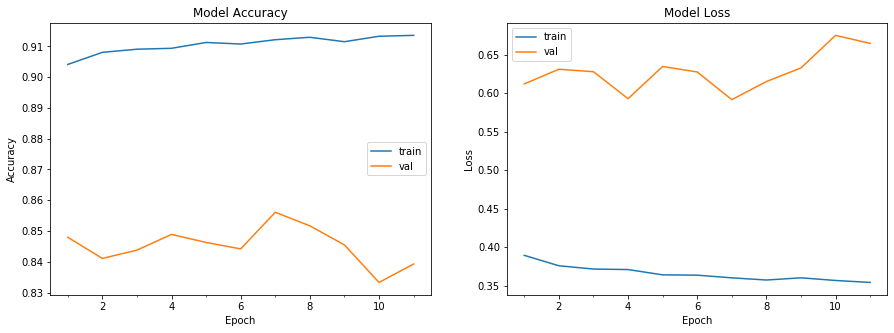

Model took to train is :
10692.382631540298


In [156]:
# plot model history

plot_model_history(model_info)
print("Model took to train is :")
print(end - start)

In [152]:
## %load_ext tensorboard
## %tensorboard --logdir graph

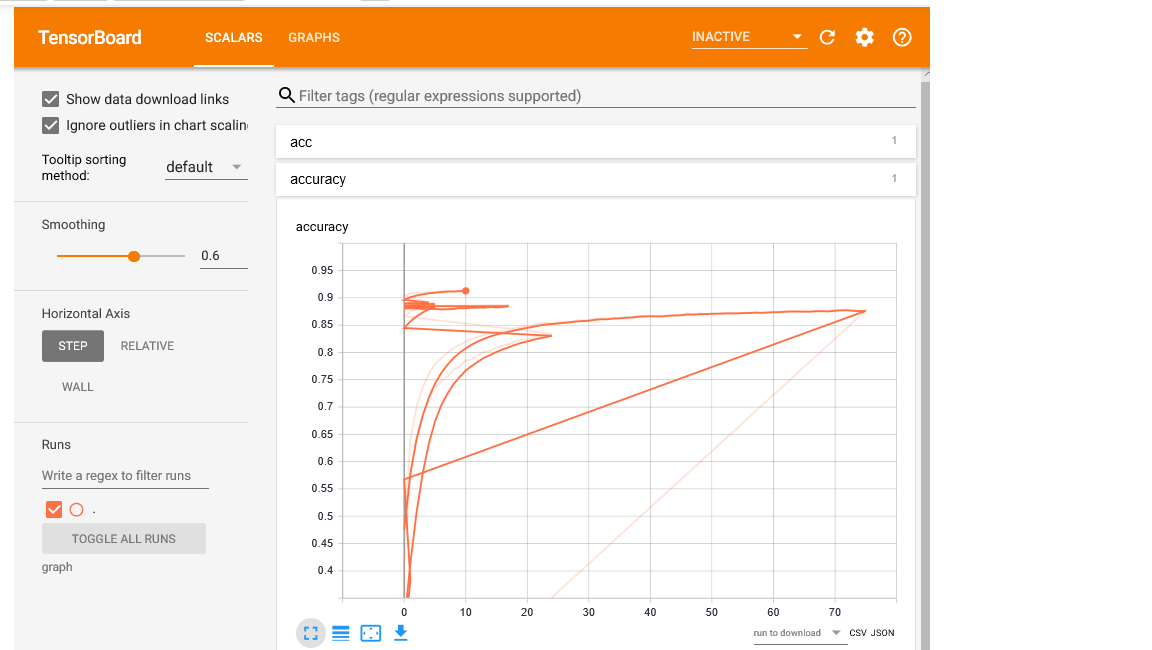

In [150]:
from IPython.display import Image
Image(filename='TrainAccuracy.png')

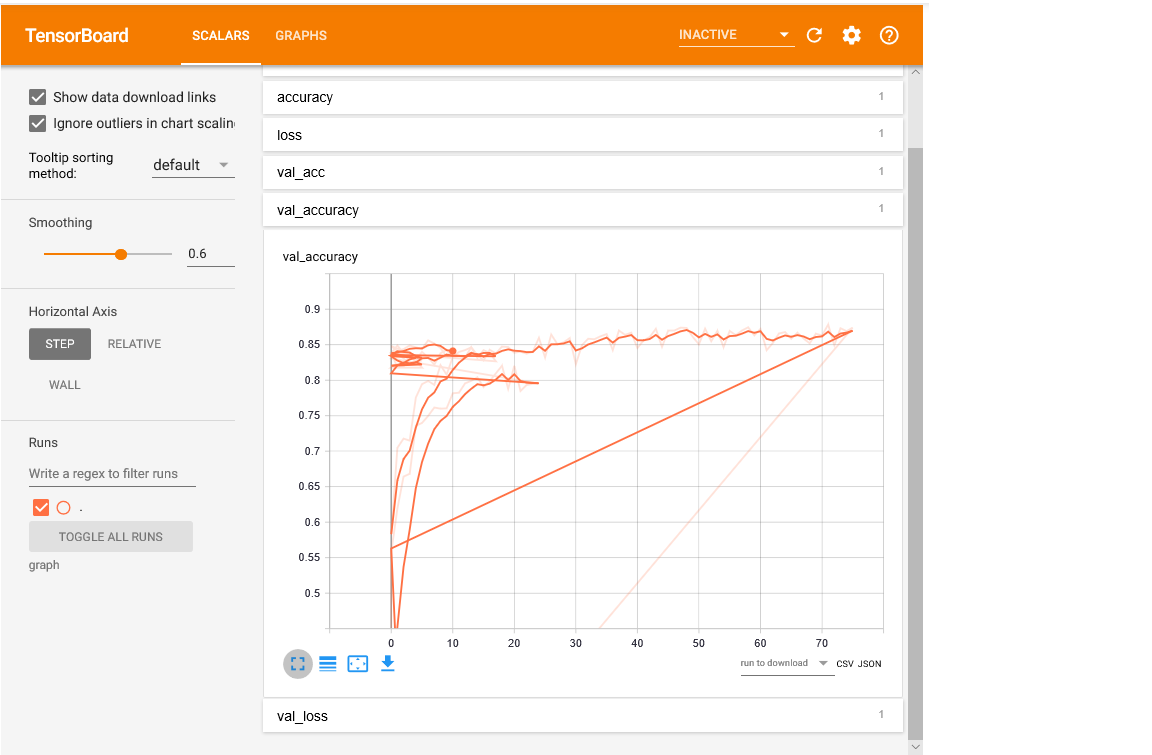

In [151]:
from IPython.display import Image
Image(filename='ValAccuracy.png')

In [134]:
def auc1(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)

def auroc(y_true, y_pred):
    return tf.py_func(auc1, (y_true, y_pred), tf.double)

In [137]:
from keras.models import load_model

custom_objects = {"auroc":auroc}

best_model = load_model('model.h5',custom_objects= custom_objects)
best_model.save("CIFARbestmodel.h5")

In [138]:
y_pred_test = model.predict_proba(test_features)

y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

# **Summary**

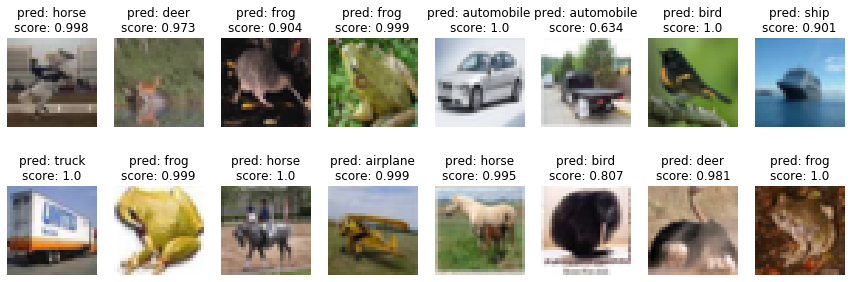

In [140]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(test_labels))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(test_features[random_index, :])
        pred_label =  class_names[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = test_labels[random_index,2]
        ax.set_title("pred: {}\nscore: {:.3}".format(pred_label, pred_proba))
plt.show()

In [141]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["train_loss", "train_auc", "test_loss","test_auc"]
x.add_row([0.36, 0.91, 0.59, 0.86])

print(x)

+------------+-----------+-----------+----------+
| train_loss | train_auc | test_loss | test_auc |
+------------+-----------+-----------+----------+
|    0.36    |    0.91   |    0.59   |   0.86   |
+------------+-----------+-----------+----------+


## Reference : 

1. https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c
2. https://medium.com/@udolf15/building-a-image-classifier-using-cnn-with-cifar-10-dataset-5682afa4f51
